In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import keras
import tensorflow.keras as K

import tensorflow.keras.backend as Kback

from keras import layers
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50
from keras.applications import vgg16
from keras.applications import inception_v3
from keras.src.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import DenseNet121, NASNetMobile, EfficientNetB0, Xception
from keras.layers import GlobalAveragePooling2D
from keras.applications.densenet import DenseNet121

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Mounted at /content/drive
Hello Google Drive!

In [ ]:
dataset="/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset"

In [ ]:
import os

dataset_folder_path = "/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset"
folder_contents = os.listdir(dataset_folder_path)

# Filter out only the directories (folders)
folders = [item for item in folder_contents if os.path.isdir(os.path.join(dataset_folder_path, item))]

# Print the list of folders
print("Folders in the dataset:")
for folder in folders:
    print(folder)


Folders in the dataset:
Normal cases
Malignant cases
Bengin cases


In [ ]:
data_dir = "/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset"
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [ ]:
def preprocess_image(file_path):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img = img / 255.0
    return img

In [ ]:
data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = preprocess_image(file_path)
        data.append(img)
        labels.append(label)

In [ ]:
data, labels = shuffle(data, labels, random_state=42)


print('Data length:', len(data))
print('labels counts:', Counter(labels))

X = np.array(data).reshape(-1, 224, 224, 3)
y = np.array(labels)

Data length: 1097
labels counts: Counter({1: 561, 2: 416, 0: 120})


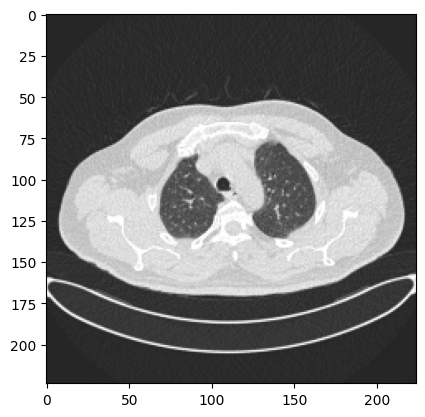

In [ ]:
plt.imshow(X[y==2][2])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


X_train, X_valid, y_train, y_valid=X_train, X_test, y_train, y_test





print('Train length:', len(X_train), X_train.shape)
print('Valid length:', len(X_valid), X_valid.shape)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
# X,y valid are used for evaluate matrix






# X_train, X_valid, y_train, y_valid=X_train, X_test, y_train, y_test











print('Train length:', len(X_train), X_train.shape)
print('Valid length:', len(X_valid), X_valid.shape)

# train_generator = train_datagen.flow(X_fold, y_fold, batch_size=8, shuffle=True)
# validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)

Train length: 877 (877, 224, 224, 3)
Valid length: 220 (220, 224, 224, 3)
Train length: 877 (877, 224, 224, 3)
Valid length: 220 (220, 224, 224, 3)


# **VGG 16**

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())


intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])


# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               6422784   
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 21178819 (80.79 MB)
Trainable params: 64

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 1s 133ms/step - loss: 0.1675 - accuracy: 0.9636
Test Loss: 0.16750763356685638
Test Accuracy: 0.9636363387107849
7/7 [==============================] - 1s 128ms/step
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       0.96      1.00      0.98       117
           2       0.97      0.95      0.96        73

    accuracy                           0.96       220
   macro avg       0.96      0.94      0.95       220
weighted avg       0.96      0.96      0.96       220



<function matplotlib.pyplot.show(close=None, block=None)>

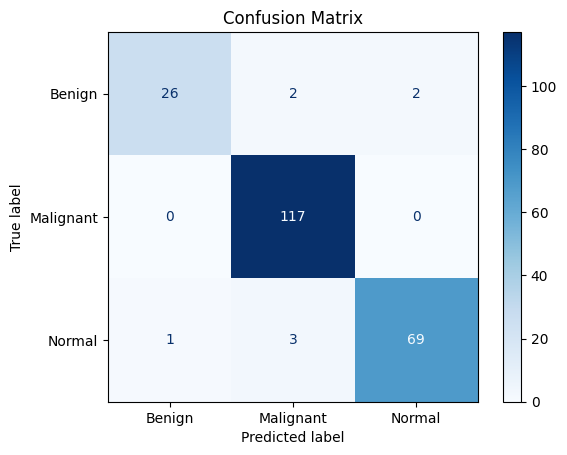

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

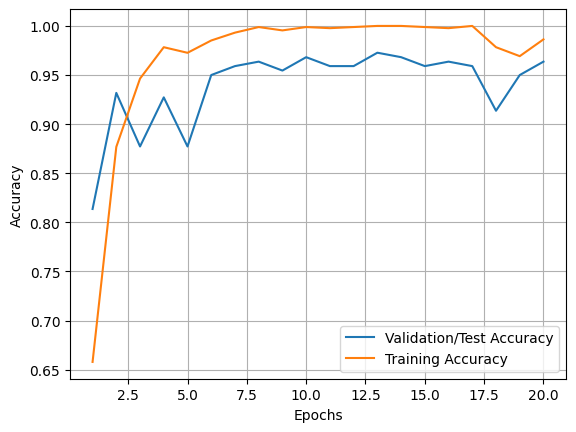

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

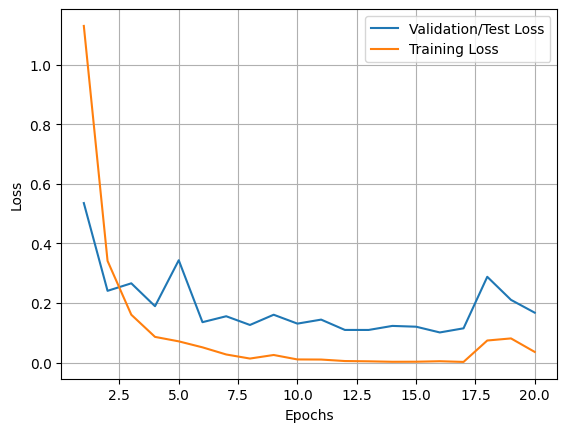

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.9889649923896499

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.9930009792910196

# **VGG 19**

In [ ]:
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())





intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])










# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




80134624/80134624 [==============================] - 5s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                       

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 1s 152ms/step - loss: 0.1350 - accuracy: 0.9682
Test Loss: 0.13497033715248108
Test Accuracy: 0.9681817889213562
7/7 [==============================] - 1s 151ms/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.97      1.00      0.98       117
           2       0.96      0.97      0.97        73

    accuracy                           0.97       220
   macro avg       0.98      0.94      0.95       220
weighted avg       0.97      0.97      0.97       220



<function matplotlib.pyplot.show(close=None, block=None)>

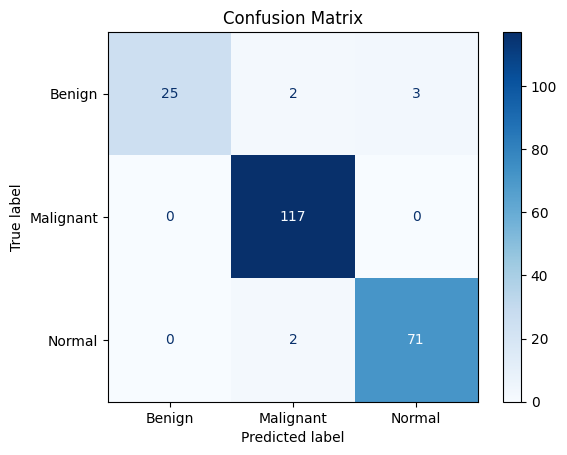

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

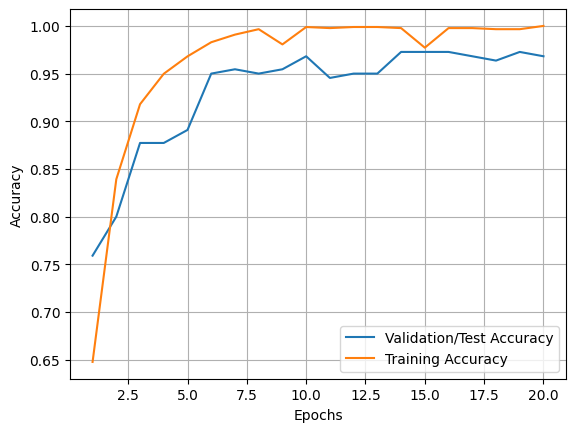

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

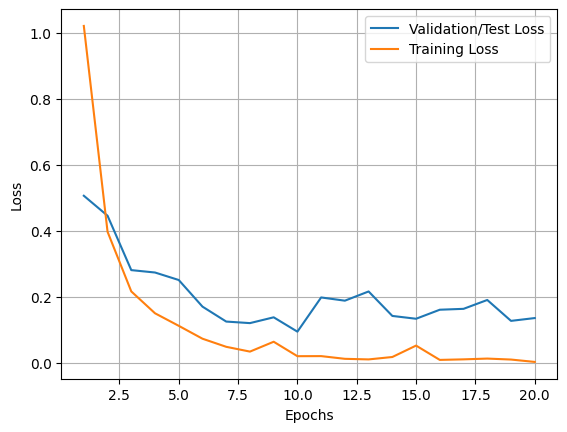

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.9925613706435624

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.9957626403427767

# **Inception V3**

In [ ]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())



intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])




# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




87910968/87910968 [==============================] - 5s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_11 (Dense)            (None, 256)               13107456  
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 3)                 195       
                                                       

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 1s 76ms/step - loss: 0.3672 - accuracy: 0.9500
Test Loss: 0.36724215745925903
Test Accuracy: 0.949999988079071
7/7 [==============================] - 2s 65ms/step
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        30
           1       0.97      1.00      0.99       117
           2       0.90      0.97      0.93        73

    accuracy                           0.95       220
   macro avg       0.96      0.89      0.92       220
weighted avg       0.95      0.95      0.95       220



<function matplotlib.pyplot.show(close=None, block=None)>

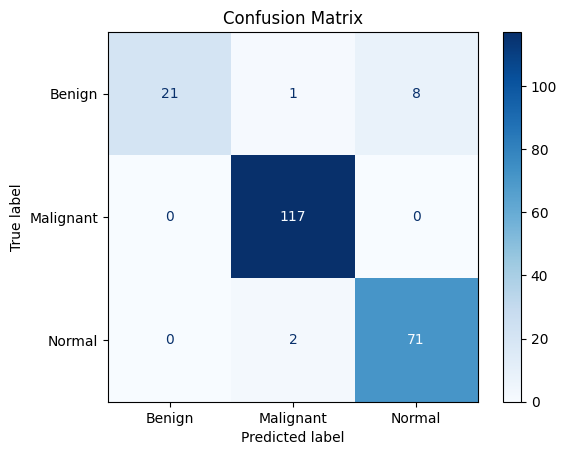

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

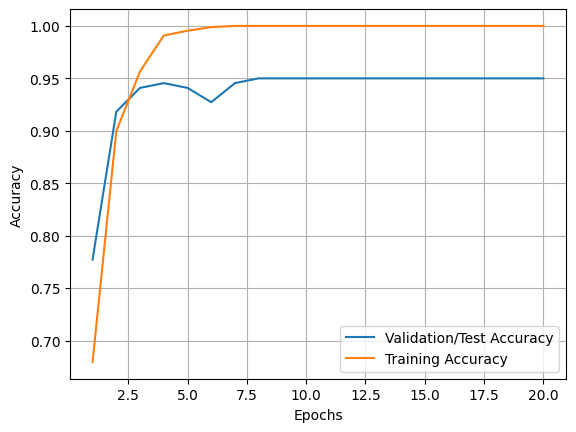

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

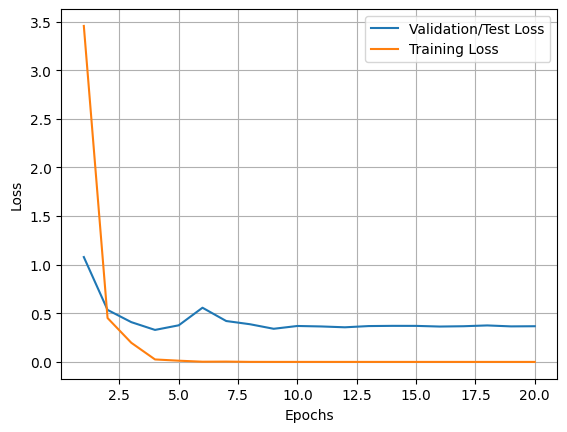

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.9748686076311648

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.9847834373795473

# **ResNet50**

In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())




intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])




# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_16 (Dense)            (None, 256)               25690368  
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 3)                 195       
                                                       

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 1s 96ms/step - loss: 0.1596 - accuracy: 0.9636
Test Loss: 0.15956978499889374
Test Accuracy: 0.9636363387107849
7/7 [==============================] - 1s 92ms/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.97      1.00      0.99       117
           2       0.93      0.96      0.95        73

    accuracy                           0.96       220
   macro avg       0.97      0.93      0.95       220
weighted avg       0.96      0.96      0.96       220



<function matplotlib.pyplot.show(close=None, block=None)>

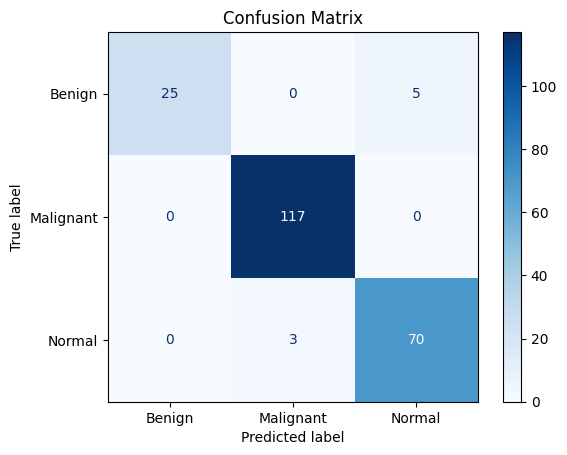

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

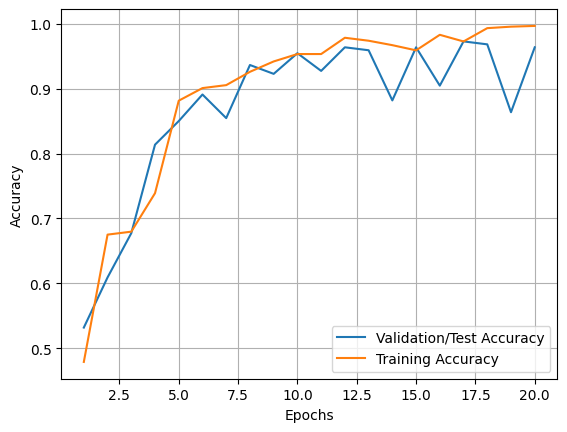

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

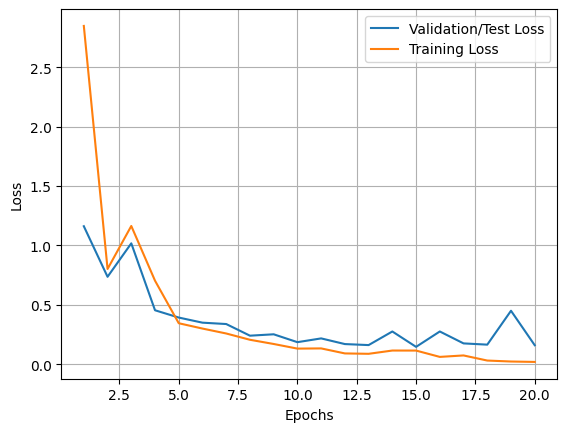

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.9892245248409631

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.9908848953508048

# **MobileNetV2**

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())



intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])



# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




9406464/9406464 [==============================] - 2s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_6 (Flatten)         (None, 62720)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               16056576  
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 3)                 19

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 0s 52ms/step - loss: 0.2757 - accuracy: 0.9818
Test Loss: 0.27566108107566833
Test Accuracy: 0.9818181991577148
7/7 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.99      1.00      1.00       117
           2       0.96      1.00      0.98        73

    accuracy                           0.98       220
   macro avg       0.98      0.96      0.97       220
weighted avg       0.98      0.98      0.98       220



<function matplotlib.pyplot.show(close=None, block=None)>

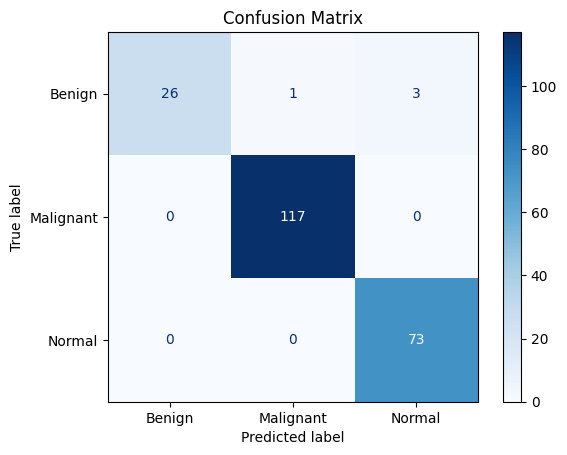

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

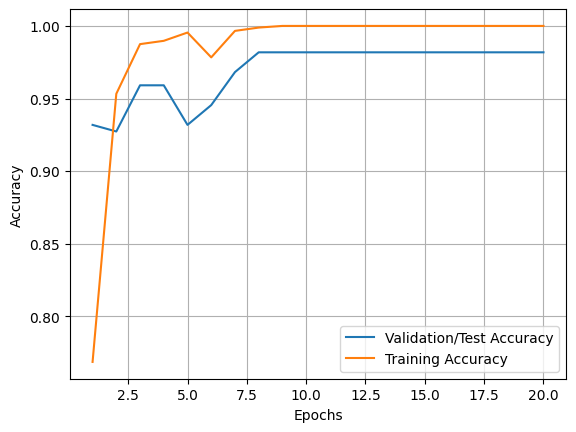

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

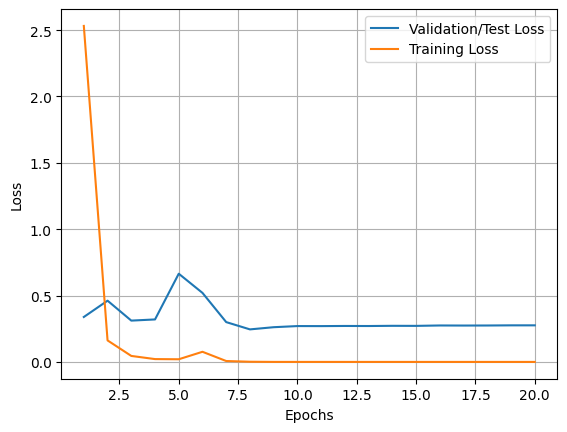

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.9823553708256906

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.9881895231197501

# **MobileNetV3 Large**

In [ ]:
base_model= keras.applications.MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())



intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])




# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




12683000/12683000 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 47040)             0         
                                                                 
 dense_26 (Dense)            (None, 256)               12042496  
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 3)                 

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 0s 51ms/step - loss: 0.3035 - accuracy: 0.9227
Test Loss: 0.30353009700775146
Test Accuracy: 0.9227272868156433
7/7 [==============================] - 1s 40ms/step
              precision    recall  f1-score   support

           0       1.00      0.57      0.72        30
           1       0.94      1.00      0.97       117
           2       0.87      0.95      0.91        73

    accuracy                           0.92       220
   macro avg       0.94      0.84      0.87       220
weighted avg       0.93      0.92      0.92       220



<function matplotlib.pyplot.show(close=None, block=None)>

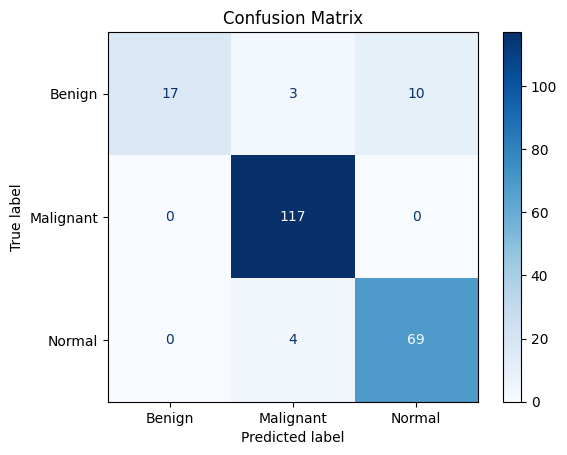

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

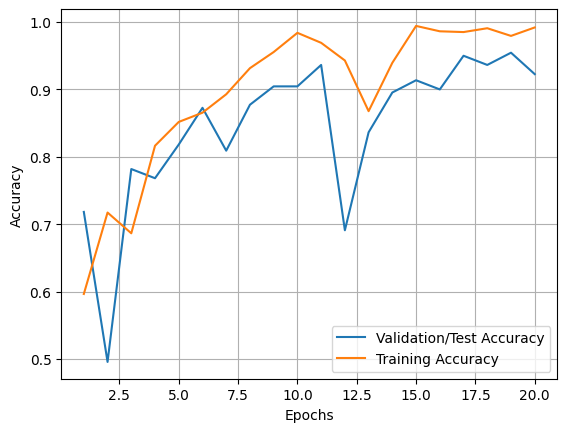

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

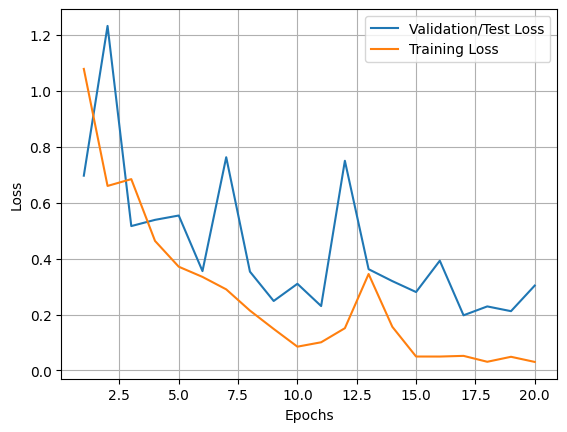

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.9794169301018617

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.9833305911851492

# **MobileNetV3 Small**

In [ ]:
base_model= keras.applications.MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())



intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])


# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




4334752/4334752 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 28224)             0         
                                                                 
 dense_31 (Dense)            (None, 256)               7225600   
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 3)                 19

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 0s 23ms/step - loss: 1.6327 - accuracy: 0.5591
Test Loss: 1.632714867591858
Test Accuracy: 0.5590909123420715
7/7 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.56      1.00      0.72       117
           2       0.50      0.08      0.14        73

    accuracy                           0.56       220
   macro avg       0.35      0.36      0.29       220
weighted avg       0.47      0.56      0.43       220



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<function matplotlib.pyplot.show(close=None, block=None)>

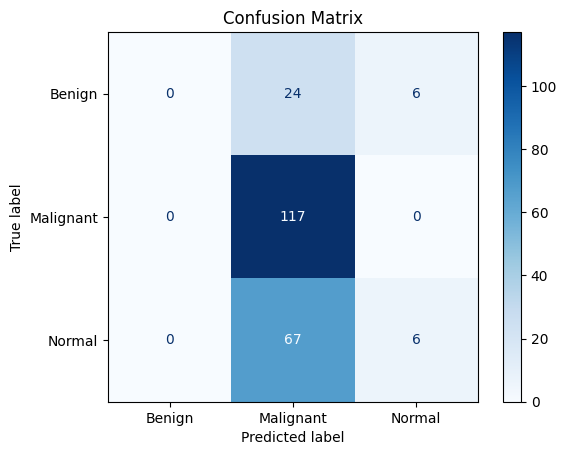

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

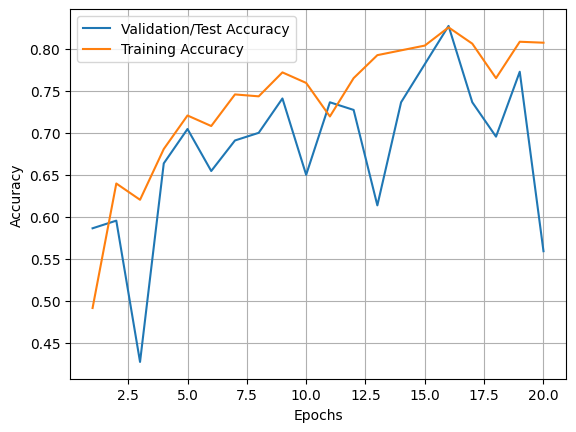

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

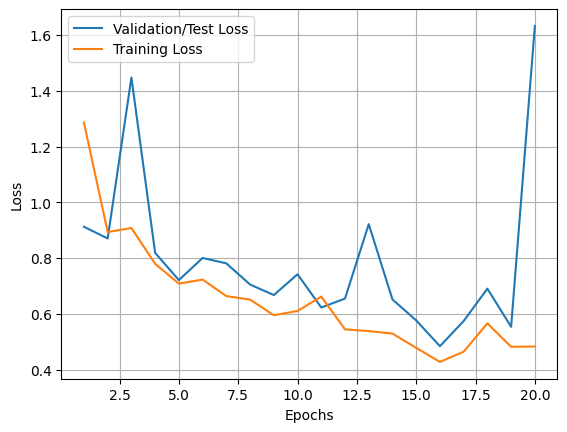

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.8375255304479049

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.8950065772888357

# **AlexNet**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization

# Create the AlexNet model
alexnet_model = Sequential()

# 1st Convolutional Layer
alexnet_model.add(Conv2D(filters=96, input_shape=(224, 224, 3),
                 kernel_size=(11, 11), strides=(4, 4), padding='valid'))
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
alexnet_model.add(BatchNormalization())

# 2nd Convolutional Layer
alexnet_model.add(Conv2D(filters=256, kernel_size=(11, 11),
                 strides=(1, 1), padding='valid'))
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
alexnet_model.add(BatchNormalization())

# 3rd, 4th, and 5th Convolutional Layers
alexnet_model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
alexnet_model.add(Activation('relu'))
alexnet_model.add(BatchNormalization())

alexnet_model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
alexnet_model.add(Activation('relu'))
alexnet_model.add(BatchNormalization())

alexnet_model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Fully Connected Layers
alexnet_model.add(Flatten())
alexnet_model.add(Dense(4096))
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.5))

alexnet_model.add(Dense(4096))
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.5))

# Output layer
alexnet_model.add(Dense(1000, activation='softmax'))  # Assuming 1000 classes for ImageNet

# Compile the model
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:


# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(alexnet_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())


intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])


# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 1000)              28041960  
                                                                 
 flatten_10 (Flatten)        (None, 1000)              0         
                                                                 
 dense_39 (Dense)            (None, 256)               256256    
                                                                 
 dense_40 (Dense)            (None, 128)               32896     
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dense_42 (Dense)            (None, 3)                 195       
                                                                 
Total params: 28339563 (108.11 MB)
Trainable params: 

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 0s 22ms/step - loss: 0.9851 - accuracy: 0.5318
Test Loss: 0.9850832223892212
Test Accuracy: 0.5318182110786438
7/7 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.53      1.00      0.69       117
           2       0.00      0.00      0.00        73

    accuracy                           0.53       220
   macro avg       0.18      0.33      0.23       220
weighted avg       0.28      0.53      0.37       220



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<function matplotlib.pyplot.show(close=None, block=None)>

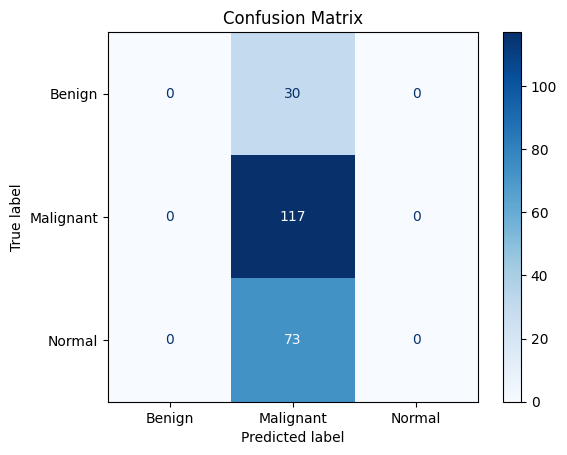

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

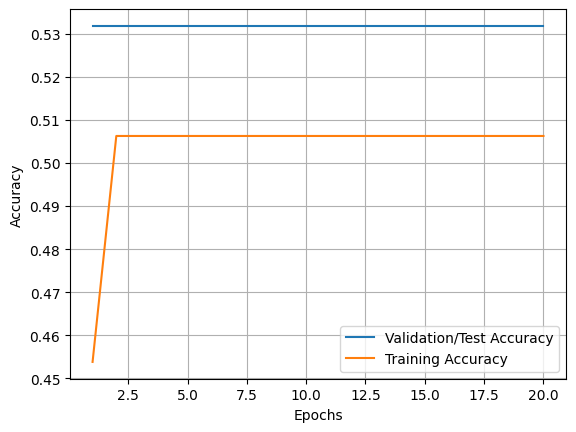

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

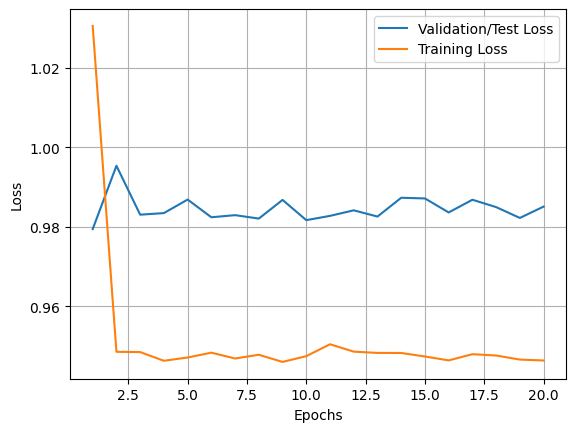

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.67659296985781

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.6963363218456431

# **Densenet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121

# Load the pre-trained DenseNet121 model (without top layers)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())


intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])



# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_11 (Flatten)        (None, 50176)             0         
                                                                 
 dense_44 (Dense)            (None, 256)               12845312  
                                                                 
 dense_45 (Dense)            (None, 128)               32896     
                                                                 
 dense_46 (Dense)            (None, 64)                8256      
                                                                 
 dense_47 (Dense)            (None, 3)                 195       
                                                      

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 1s 99ms/step - loss: 0.1753 - accuracy: 0.9818
Test Loss: 0.175319105386734
Test Accuracy: 0.9818181991577148
7/7 [==============================] - 2s 97ms/step
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.98      1.00      0.99       117
           2       0.97      1.00      0.99        73

    accuracy                           0.98       220
   macro avg       0.99      0.96      0.97       220
weighted avg       0.98      0.98      0.98       220



<function matplotlib.pyplot.show(close=None, block=None)>

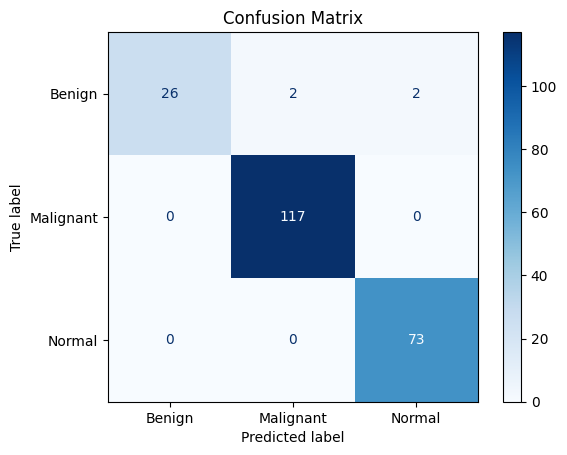

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

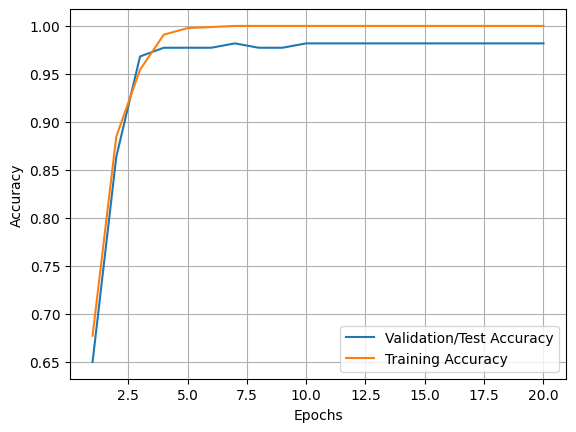

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

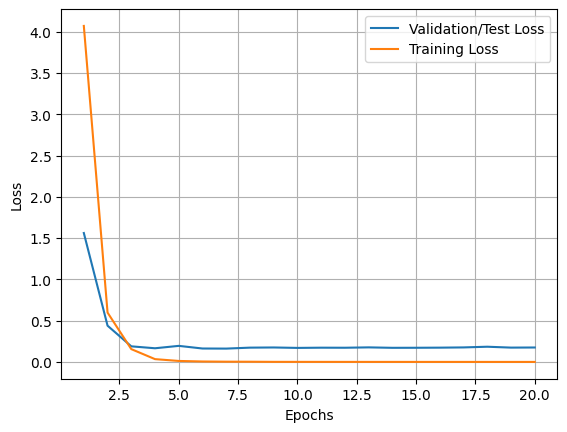

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.983621485904591

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.9890033139475604

# **Xception**

In [ ]:
from tensorflow.keras.applications import Xception

# Create the Xception base model
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())



intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])


# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




83683744/83683744 [==============================] - 5s 0us/step
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_12 (Flatten)        (None, 100352)            0         
                                                                 
 dense_49 (Dense)            (None, 256)               25690368  
                                                                 
 dense_50 (Dense)            (None, 128)               32896     
                                                                 
 dense_51 (Dense)            (None, 64)                8256      
                                                                 
 dense_52 (Dense)            (None, 3)                 195       
                                                      

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 1s 138ms/step - loss: 0.2473 - accuracy: 0.9636
Test Loss: 0.24730530381202698
Test Accuracy: 0.9636363387107849
7/7 [==============================] - 2s 141ms/step
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.97      1.00      0.99       117
           2       0.96      0.97      0.97        73

    accuracy                           0.96       220
   macro avg       0.95      0.92      0.94       220
weighted avg       0.96      0.96      0.96       220



<function matplotlib.pyplot.show(close=None, block=None)>

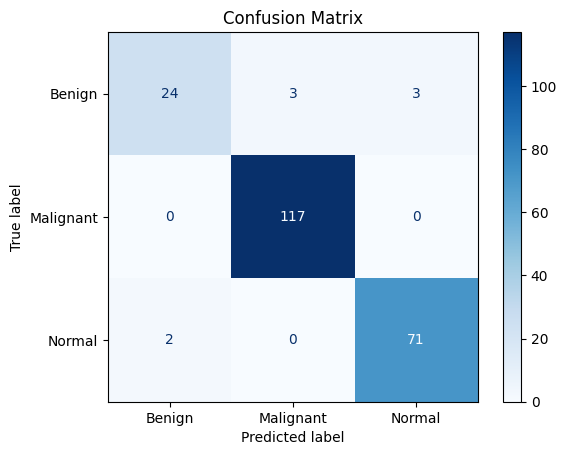

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

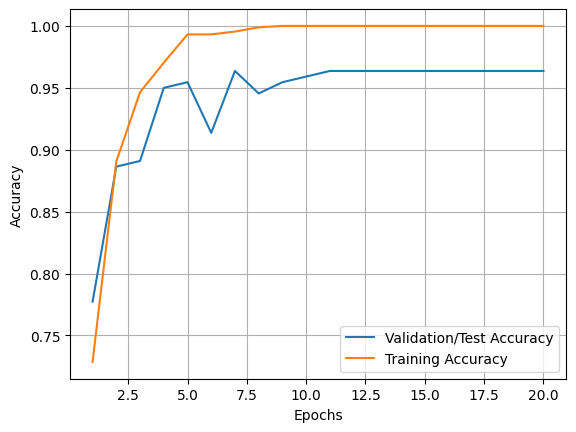

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

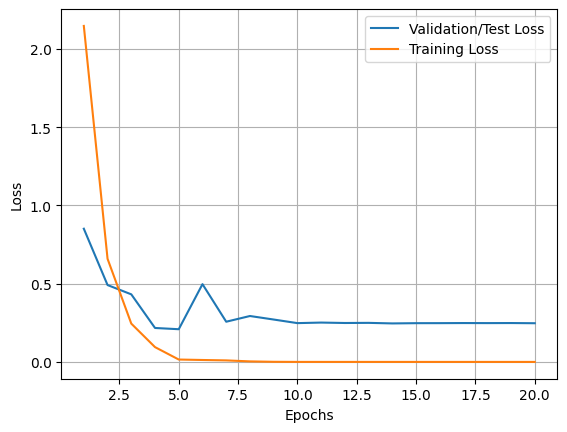

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.981728655244637

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.987663689189468

# **EfficientNet50**

In [ ]:


# Create the Xception base model

base_model = EfficientNetB0(input_shape = (224, 224, 3),
                         include_top = False,
                         weights = 'imagenet')


# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())



intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])


# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten_13 (Flatten)        (None, 62720)             0         
                                                                 
 dense_54 (Dense)            (None, 256)               16056576  
                                                                 
 dense_55 (Dense)            (None, 128)               32896     
                                                                 
 dense_56 (Dense)            (None, 64)                8256      
                                                                 
 dense_57 (Dense)            (None, 3)                

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_valid,y_valid)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_valid, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_2))

7/7 [==============================] - 0s 61ms/step - loss: 1.1464 - accuracy: 0.5318
Test Loss: 1.1463688611984253
Test Accuracy: 0.5318182110786438
7/7 [==============================] - 2s 69ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.53      1.00      0.69       117
           2       0.00      0.00      0.00        73

    accuracy                           0.53       220
   macro avg       0.18      0.33      0.23       220
weighted avg       0.28      0.53      0.37       220



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<function matplotlib.pyplot.show(close=None, block=None)>

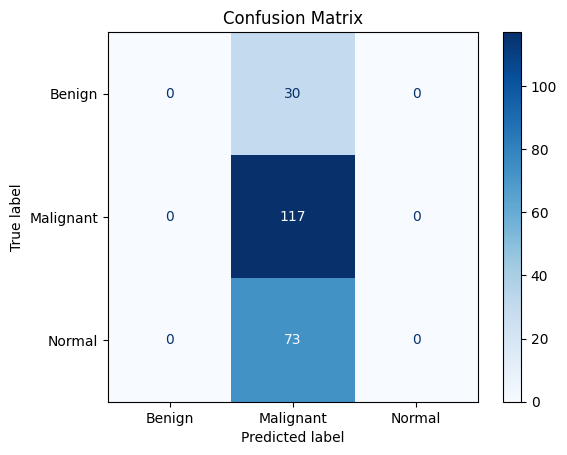

In [ ]:
cm= confusion_matrix(y_true=y_valid, y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

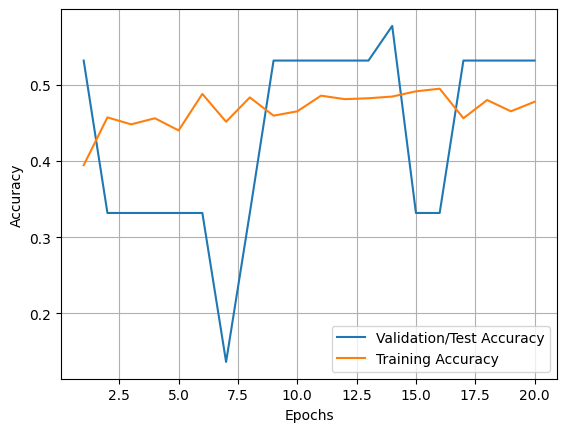

In [ ]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

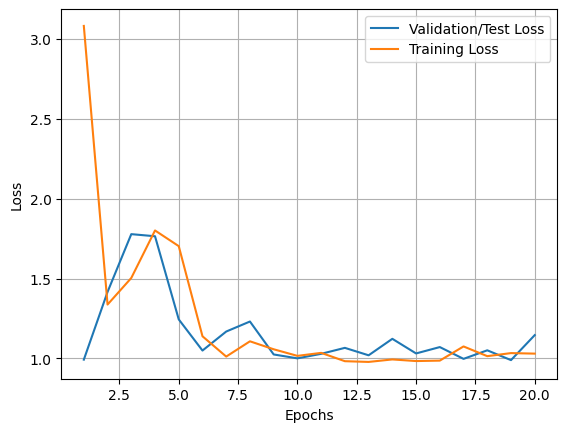

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#One vs One
roc_auc_score(y_valid, y_pred,multi_class='ovo')

0.6872250191884895

In [ ]:
#One vs Rest
roc_auc_score(y_valid, y_pred,multi_class='ovr')

0.7214463105344753